In [34]:
#uncomment this to see the names of the different configurations that can be loaded in
from config import *

fieldlist=[]
for info in field._registry:
    fieldlist.append(info.name)
print('Names of available configurations for fields:, ', fieldlist)

mosaiclist=[]
for info in mosaic._registry:
    mosaiclist.append(info.name)
print('\nNames of available configurations for mosaics:, ', mosaiclist)

Names of available configurations for fields:,  ['Field1', 'Field2', 'Field3', 'Field5', 'Field6', 'Field7', 'Field8', 'Field9', 'Field10', 'Field11', 'Field12', 'Field13', 'FieldA', 'FieldB', 'FieldC', 'FieldD', 'FieldE', 'FieldF', 'FieldG', 'FieldH', 'FieldI', 'FieldK', 'FieldL', 'FieldM', 'FieldO', 'FieldP', 'FieldQ', 'FieldR', 'FieldS', 'FieldT', 'FieldU', 'FieldV', 'FieldW', 'FieldX', 'FieldY', 'H_North', 'H_South', 'ArchE', 'ArchNE', 'ArchNW', 'ArchSE', 'ArchW', 'FieldA9', 'FieldB9', 'FieldC9', 'FieldF9', 'FieldI9', 'FieldL9', 'FieldN9']

Names of available configurations for mosaics:,  ['Mosaic25', 'Mosaic37']


In [35]:
#import configuration for selected file
from config import FieldN9 as field
from config import wavelength, segdetsig, finddetsig, bkgbox #import additional common paramters
from config import dpath, dpathalt, ds9path #import additional common paramters

In [36]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.table import Table
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join
from astropy.coordinates import SkyCoord

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

from regions import read_ds9

#newest stuff for psf photo
from photutils.psf import DAOGroup, IntegratedGaussianPRF
from astropy.modeling.fitting import LevMarLSQFitter
from photutils.psf import BasicPSFPhotometry
from photutils.datasets import make_gaussian_sources_image
from astropy.nddata import Cutout2D

In [37]:
def performApPhoto(data,tmap,wcs,sourceCoords,radii,rin,rout,plot=True):

	#create aperture objects for all specified radii 
	apertures =[SkyCircularAperture(sourceCoords, r=r*0.786*u.arcsec) for r in radii]

	#do aperture photometry on data using defined apertures 
	phot_table = aperture_photometry(data, apertures,wcs=wcs,error=errormap,method='exact')

	#now estimate local backgrounds using background annulus
	annulus_aperture = SkyCircularAnnulus(sourceCoords, r_in=rin*0.786*u.arcsec, r_out=rout*0.786*u.arcsec) #define annulus

	#convert to pixel coords for calcs and plotting
	pix_aperture = apertures[1].to_pixel(wcs) #only use one of the apertures for this. The default is the 2nd in the list
	pix_annulus_aperture = annulus_aperture.to_pixel(wcs)

	#store area value of annulus in case we want it later
	phot_table['pixAnnArea']=pix_annulus_aperture.area

    
    
    
	#now do robust statistics on the background annuli
	#create lists to store information for later
	bkg_median=[]
	bkg_mean=[]
	bkg_std=[]
	appmasks=[]

	#create mask array for the annuli
	annulus_masks = pix_annulus_aperture.to_mask(method='exact')

	#for each of the annuli loop through and calculate stats using sigma cliped stats
	for mask in annulus_masks:
		annulus_data = mask.multiply(data)
		maskdata=mask.data

		#do statistics
		annulus_data_1d = annulus_data[maskdata > 0]
		meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
		bkg_median.append(median_sigclip)
		bkg_mean.append(meansc)
		bkg_std.append(stdsc)
		appmasks.append(mask.data)

	#store values in numpy arrays
	bkg_median = np.array(bkg_median)
	bkg_mean = np.array(bkg_mean)
	bkg_std = np.array(bkg_std)

	#add columns for background information and also background subtracted apertures
	phot_table['ann_bkg_med'] = bkg_median
	phot_table['ann_bkg_mean'] = bkg_mean 
	phot_table['ann_bkg_std'] = bkg_std 


    
	#information from exposure time maps
	#create lists to store information for later
	texp_mean=[]
	texp_med=[]
	texpmasks=[]

	#create mask array for the exp time map apertures
	ap_masks = pix_aperture.to_mask(method='exact')

	#for each of the annuli loop through and calculate stats using sigma cliped stats
	for mask in ap_masks:
		ap_texp = mask.multiply(tmap)
        
		#do statistics
		ap_texp_1d = ap_texp[mask.data > 0]
		meansc, median_sigclip, stdsc = sigma_clipped_stats(ap_texp_1d)
		texp_med.append(median_sigclip)
		texp_mean.append(meansc)
		texpmasks.append(mask.data)

	phot_table['texp_med'] = texp_med
	phot_table['texp_mean'] = texp_mean
    


	#caclulate background subtracted photometry and snr for each source
	for i in range(0,len(radii)):
		#coloumn names and from the phot table and new columns we'll add
		cname1='aperture_sum_'+str(i)
		cname2='aperture_sum_err_'+str(i)
		newcol1='aper_sum_bkgsub_'+str(radii[i])+'pix'
		newcol2='aper_snr_'+str(radii[i])+'pix'
		newcol3='aper_area_'+str(radii[i])+'pix'
        
		#get pixel aperture areas for calculations
		pixel_ap = apertures[i].to_pixel(wcs)
		pixarea=pixel_ap.area
		#get background subracted photo by subtracting median annulus value from each pixel in aperture
		phot_table[newcol1]=(phot_table[cname1]/pixarea-phot_table['ann_bkg_med'])*pixarea
		#calculate SNR following equation from forcast photometry cookbook -https://sofia-data-analysis-cookbooks.readthedocs.io/en/latest/FORCAST-photometry_detailed.html
		phot_table[newcol2]=phot_table[newcol1]/np.sqrt(2*np.pi*(radii[i]*phot_table['ann_bkg_std']/phot_table[newcol1])**2+(header['ERRCALF']/header['CALFCTR'])**2+0.0025) 
		phot_table[newcol3]=pixarea
		
		#rename aperture columns in table to be more descriptive
		rename1='aperture_sum_'+str(radii[i])+'pix'
		rename2='aperture_sum_err_'+str(radii[i])+'pix'
		phot_table.rename_column(cname1, rename1)
		phot_table.rename_column(cname2, rename2)

        
    
	#add additonal information for wavelength and which field 
	phot_table['Field']=field.name
	phot_table['wv']=wavelength
    

    
    
	if plot:
		#show figure with apertures overlayed
		plt.figure(figsize=(8,8))
		norm = simple_norm(data, 'sqrt', percent=99)
		plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
		plt.colorbar()

		ap_patches = pix_aperture.plot(color='white', lw=2,
	                          label='Photometry aperture')
		ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
		                                    label='Background annulus')
		handles = (ap_patches[0], ann_patches[0])
		plt.legend(loc='best', facecolor='#458989', labelcolor='white',
		           handles=handles, prop={'weight': 'bold', 'size': 11})
		plt.show()
    
    
    
	return phot_table

In [38]:
''' Not needed anymore
def modTabCol2(merged_table):
	#merged_table.remove_columns(['xcenter','ycenter','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])
	
	#rename some columns to avoid possible confusion
	merged_table.rename_column('aperture_sum_0', 'aperture_sum_4pix')
	merged_table.rename_column('aperture_sum_err_0', 'aperture_sum_err_4pix')
	merged_table.rename_column('aperture_sum_1', 'aperture_sum_7pix')
	merged_table.rename_column('aperture_sum_err_1', 'aperture_sum_err_7pix')
	merged_table.rename_column('aperture_sum_2', 'aperture_sum_12pix')
	merged_table.rename_column('aperture_sum_err_2', 'aperture_sum_err_12pix')
	
	#compute area for the different size apertures 
	ap4pixarea=merged_table['pixApArea']*(4/7.)**2
	ap7pixarea=merged_table['pixApArea']*(7/7.)**2
	ap12pixarea=merged_table['pixApArea']*(12/7.)**2
	
		#calculate local bkg subtracted photometry for the other apertures 
	merged_table['aper_sum_bkgsub_4pix']=(merged_table['aperture_sum_4pix']/ap4pixarea-merged_table['ann_bkg_med'])*ap4pixarea
	merged_table['aper_sum_bkgsub_7pix']=(merged_table['aperture_sum_7pix']/ap7pixarea-merged_table['ann_bkg_med'])*ap7pixarea
	merged_table['aper_sum_bkgsub_12pix']=(merged_table['aperture_sum_12pix']/ap12pixarea-merged_table['ann_bkg_med'])*ap12pixarea
	
	#calculate snr for each aperture - updated using https://sofia-data-analysis-cookbooks.readthedocs.io/en/latest/FORCAST-photometry_detailed.html
	merged_table['aper_snr_4pix']=merged_table['aper_sum_bkgsub_4pix']/np.sqrt(2*np.pi*(4*merged_table['ann_bkg_std']/merged_table['aper_sum_bkgsub_4pix'])**2+(header['ERRCALF']/header['CALFCTR'])**2+0.0025) 
	merged_table['aper_snr_7pix']=merged_table['aper_sum_bkgsub_7pix']/np.sqrt(2*np.pi*(7*merged_table['ann_bkg_std']/merged_table['aper_sum_bkgsub_7pix'])**2+(header['ERRCALF']/header['CALFCTR'])**2+0.0025)
	merged_table['aper_snr_12pix']=merged_table['aper_sum_bkgsub_12pix']/np.sqrt(2*np.pi*(12*merged_table['ann_bkg_std']/merged_table['aper_sum_bkgsub_12pix'])**2+(header['ERRCALF']/header['CALFCTR'])**2+0.0025)
	
	
	
	#add additonal information for wavelength and which field 
	merged_table['Field']=field.name
	merged_table['wv']=wavelength
	
	#display table
	return merged_table
'''

" Not needed anymore\ndef modTabCol2(merged_table):\n\t#merged_table.remove_columns(['xcenter','ycenter','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])\n\t\n\t#rename some columns to avoid possible confusion\n\tmerged_table.rename_column('aperture_sum_0', 'aperture_sum_4pix')\n\tmerged_table.rename_column('aperture_sum_err_0', 'aperture_sum_err_4pix')\n\tmerged_table.rename_column('aperture_sum_1', 'aperture_sum_7pix')\n\tmerged_table.rename_column('aperture_sum_err_1', 'aperture_sum_err_7pix')\n\tmerged_table.rename_column('aperture_sum_2', 'aperture_sum_12pix')\n\tmerged_table.rename_column('aperture_sum_err_2', 'aperture_sum_err_12pix')\n\t\n\t#compute area for the different size apertures \n\tap4pixarea=merged_table['pixApArea']*(4/7.)**2\n\tap7pixarea=merged_table['pixApArea']*(7/7.)**2\n\tap12pixarea=merged_table['pixApArea']*(12/7.)**2\n\t\n\t\t#calculate local bkg subtracted photometry for the other apertures \n\tmerged_table['aper_sum

In [39]:
#change directory to data location - provide alternate if working between two different pc's
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(field.filename)
header=hdu[0].header

#pull the first image plane
ims=hdu[0].data

#use the first image plane shape to determine how to unpack the rest of the data
if len(np.shape(ims))==2:
    data=ims
    varmap=hdu[1].data
    tmap=hdu[2].data
elif len(np.shape(ims))==3:
    data=ims[0]
    varmap=ims[1]
    tmap=ims[2]
    hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
hdu.close()

#define wcs object for header
wcsmap=WCS(hdu[0].header)

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

In [40]:
#create background model for image using median method
bkg_estimator = MedianBackground() #MMMBackground() #SExtractorBackground() #MedianBackground()
bkg_data = Background2D(data,(bkgbox, bkgbox), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image for photometry
data_bkgsub = data - bkg

In [41]:
#load in the catalog files if they exist
if os.path.isfile(field.name+'_'+str(wavelength)+'um_seg.fits'):
    segTab=Table.read(field.name+'_'+str(wavelength)+'um_seg.fits')
else:
    segTab=None
    
if os.path.isfile(field.name+'_'+str(wavelength)+'um_dao.fits'):   
    daoTab=Table.read(field.name+'_'+str(wavelength)+'um_dao.fits')
else:
    daoTab=None

In [42]:
#Get Source coordinates from table
if segTab is not None:
    sourcesseg=segTab['sky_centroid']
    
if daoTab is not None:
    sourcesdao=daoTab['sky_centroid']


In [43]:
#check if user defined ds9 file exists
if os.path.isfile(field.name+'_ds9.reg'):
    sourcesDS9=read_ds9(field.name+'_ds9.reg')

    clist=[]
    
    for source in sourcesDS9:
        if source.visual['color']=='green':
            sc=source.center
            ra=sc.ra.value
            dec=sc.dec.value
            a=(ra,dec)
            clist.append(a)
            
    ds9sc=SkyCoord(clist,unit=u.deg)
    usersources=True
    print('Number of user defined DS9 sources found: ', len(clist))  
else:
    usersources=False
    print('No user defined DS9 sources found')

No user defined DS9 sources found


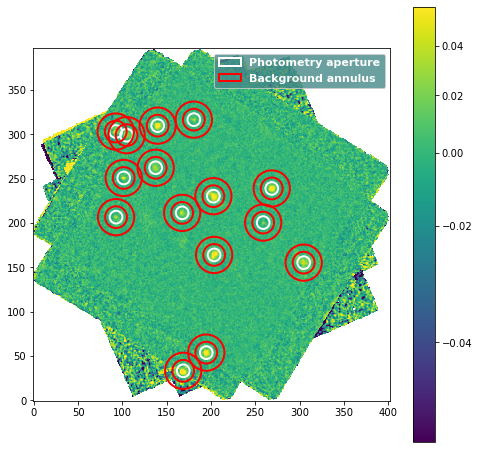

In [44]:
#radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below) - old
#radii = [3.5,3.75,4.0,4.25,4.5,4.75,5,5.25,5.5,5.75,6.0,10] #define aperture radii & construct apertures (line below) - new

radii = [4,7,12] #aperture radii to use in photoemtry - units are pixels
r_in = 12  #inner radius for background annulus - units are pixels
r_out = 20  #outer radius for background annulus - units are pixels

if segTab is not None:
    SegPhotTable=performApPhoto(data_bkgsub,tmap,wcsmap,sourcesseg,radii,r_in,r_out,plot=True)

    #display the photometry table
    SegPhotTable
else:
    print('No sources found in segmentation map')

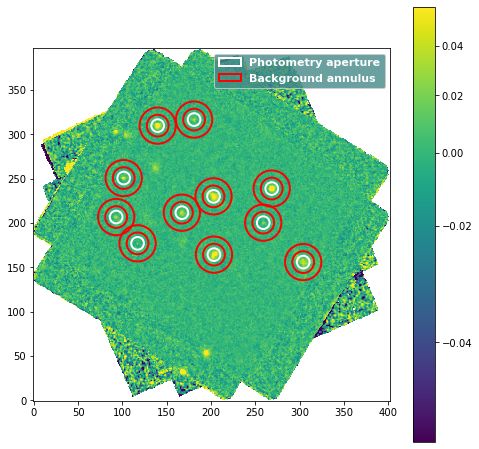

id,xcenter,ycenter,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_7pix,aperture_sum_err_7pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_7pix,aper_snr_7pix,aper_area_7pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,int32
1,304.0290816885555,155.92831368630524,"266.02008285995663,-29.42245942942512",1.5131054921683924,0.7388360072338334,2.9142693664258474,1.2938613716560434,4.552342062414734,2.2252647904391565,842.3887938920872,0.0008764274605095638,0.0015019399262249896,0.005331950784049139,478.2879500000003,475.3428951995065,1.4669622002063578,22.13767894375258,52.649299618255455,2.7729555347921155,42.78097323034158,161.23848008090735,4.137052434756421,61.224853912756316,473.8436965642991,FieldN9,25
2,203.35865208735822,164.34482408473804,"266.044739408885,-29.420666448471252",2.7538480948274016,0.7019919899333831,4.374832477907318,1.230490720986149,4.9605179768372984,2.1199607187241103,842.3887938920872,6.505912352257399e-06,4.045012661416616e-05,0.0038588337309544583,575.4245000000004,569.9245334236717,2.753505563098677,48.22232864564988,52.649299618255455,4.373783474488101,76.10735256887347,161.23848008090735,4.9574351912787815,82.49575468825343,473.8436965642991,FieldN9,25
3,117.13218570023778,177.0785173120152,"266.0658573727091,-29.4179484944126",-0.0061835738973211206,0.7126979519563545,0.023328383893178047,1.2470123744469792,-0.13031651256006463,2.1388542884053554,842.3887938920872,0.00012470109455635055,0.00034621091904579504,0.004732537861346997,575.4245000000004,571.6837768100992,-0.012748999187342824,-0.003424996688749483,52.649299618255455,0.003221768942486575,0.00012499876115216294,161.23848008090735,-0.18940534017025998,-0.25133030652290406,473.8436965642991,FieldN9,25
4,258.9540374194633,200.41342672162037,"266.0311241920377,-29.41297097153735",0.20494700464021845,0.7402015812843035,0.0752196675802409,1.2879077806099852,0.22120127584491261,2.16535127267839,842.3887938920872,-9.17479760751025e-05,-0.00026917651647075124,0.0037784355632580206,478.2879500000003,481.0761987291568,0.20977747132196506,1.1106155521027277,52.649299618255455,0.09001297179308988,0.12186741461309569,161.23848008090735,0.264675475980632,0.6113173350442382,473.8436965642991,FieldN9,25
5,92.97122414265255,206.76918530830883,"266.07177309613286,-29.411613487092882",0.7619360264071835,0.7351178064170225,0.8034654526715745,1.2842962624645942,0.7187106040670641,2.198662955896975,842.3887938920872,-9.638379476874226e-05,-0.00031802580384838254,0.004802201059923694,477.8025000000003,487.64326249465125,0.7670105656963074,9.165086008363083,52.649299618255455,0.8190062292445166,7.010615750200542,161.23848008090735,0.7643814576691798,3.881857059606111,473.8436965642991,FieldN9,25
6,167.14498664414404,211.6680475465153,"266.0536080845327,-29.410570631401896",0.9698984982077467,0.7006709744904887,1.5378211478903632,1.227247742357474,1.7787413199613649,2.10387376848691,842.3887938920872,-0.00021131874655951362,-0.00036160718789355055,0.003448394147314838,575.4245000000004,571.8300771775204,0.9810242822103127,14.951541143266809,52.649299618255455,1.5718938613982218,23.316880935226635,161.23848008090735,1.8788733759844591,24.035328409122695,473.8436965642991,FieldN9,25
7,202.83988237227376,230.09831097329155,"266.0448666510897,-29.40663903934708",2.439046101046149,0.6991656689294967,4.1799685138899845,1.2237509365860124,5.018418780912038,2.10140075856156,842.3887938920872,-8.102128178313426e-05,-0.00017593359974307638,0.0038751628971636907,575.4245000000004,572.9814330220768,2.4433118147862043,42.430648937794636,52.649299618255455,4.193032262218904,72.7

In [45]:
DaoPhotTable=performApPhoto(data_bkgsub,tmap,wcsmap,sourcesdao,radii,r_in,r_out,plot=True)

#display the table
DaoPhotTable

In [46]:
if usersources:
    UserPhotTable=performApPhoto(data_bkgsub,tmap,wcsmap,ds9sc,radii,r_in,r_out,plot=True) #changed for user sources
    
    #add sky_centriod to table
    UserPhotTable['sky_centroid']=ds9sc
    xs,ys=ds9sc.to_pixel(wcsmap)
    UserPhotTable['xcentroid']=xs
    UserPhotTable['ycentroid']=ys

    #display the table
    UserPhotTable

In [47]:
#fix id keywords in tables so theu can be merged
try:
    segTab.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

#try:
#    daoTab.rename_column('label', 'id')
#except:
#    print('Do nothing because keyword is already changed.')

In [48]:
#merge Tables
mtSeg = join(segTab, SegPhotTable, keys='id')
mtDao = join(daoTab, DaoPhotTable, keys='id')

In [49]:
''' No longer needed
mtSeg=modTabCol2(merged_table_seg)
mtDao=modTabCol2(merged_table_dao)

if usersources:
    mtds9=modTabCol(UserPhotTable)
'''

' No longer needed\nmtSeg=modTabCol2(merged_table_seg)\nmtDao=modTabCol2(merged_table_dao)\n\nif usersources:\n    mtds9=modTabCol(UserPhotTable)\n'

In [50]:
#write out the resulting tables to file - change these from ascii to fits...
ascii.write(mtSeg, field.name+'_'+str(wavelength)+'um_segCat.dat', overwrite=True)
ascii.write(mtDao, field.name+'_'+str(wavelength)+'um_daoCat.dat', overwrite=True)

if usersources:
    ascii.write(mtds9, field.name+'_'+str(wavelength)+'um_usrCat.dat', overwrite=True)

In [ ]:
### to do... Add shape fitting before outputting the final files...
### Also add a line for dropping unwatned columns

In [ ]:
#new addition to include FWHM measurements for DAO
def doPSFphoto(image,bkgmodel,sourceTable,sigma_init,plotting=False): 
	 #create initial guess positions for fitting routine
	
	initTab=Table()
	initTab['x_0']=sourceTable['xcentroid']
	initTab['y_0']=sourceTable['ycentroid']
	initTab['flux']=sourceTable['aper_sum_bkgsub_5.0as']
	
	try:
		initTab['sigma_0']=sourceTable['fwhm']
	except:
		initTab['sigma_0']=2.5
	
	daogroup = DAOGroup(crit_separation=8)
	mmm_bkg = MedianBackground() #MedianBackground()#MMMBackground()
	fitter = LevMarLSQFitter()
	gaussian_prf = IntegratedGaussianPRF(sigma=sigma_init)
	gaussian_prf.sigma.fixed = False
	mmm_bkg.sigma_clip.fixed = False
	
	basic_phot_obj=BasicPSFPhotometry(group_maker=daogroup, bkg_estimator=mmm_bkg, psf_model=gaussian_prf, fitter=fitter, fitshape=(11, 11),extra_output_cols='sigma_unc')
	
	photB_results = basic_phot_obj(image,init_guesses=initTab) #must provide initial guesses as an astropy table with columns x_0 and y_0 in pixel coords
	
	results=photB_results
	#results=photB_results[photB_results['flux_fit']>0]
	#results=results[(results['sigma_fit']>0) & (results['sigma_fit']<14) ]
	
	sources = Table()
	sources['flux'] = results['flux_fit']
	sources['x_mean'] = results['x_fit']
	sources['y_mean'] = results['y_fit']
	sources['x_stddev'] = results['sigma_fit']
	sources['y_stddev'] = sources['x_stddev']
	#sources['theta'] = [0] * 2
	
	modelimage = make_gaussian_sources_image(np.shape(data), sources)
	
	#residual=data-modelimage
	residual=data-(modelimage+bkgmodel) #include bkg model   
	    
	chivals=[]
	
	for source in photB_results:
		spos=(np.int(source['x_fit']),np.int(source['y_fit']))
		cutout=Cutout2D(residual,spos,15)
		#print(np.sum(cutout.data))
		fudge=100.
		chivals.append((np.nansum(cutout.data)/21.)**2*100)
		
	results['psfFitChi']=chivals
	#print(chivals)
	
	#rename flux initial guess in table 
	results.rename_column('flux', 'flux_init')
	
	if plotting==True:
		#a few diagnostic plots to examine background contributions to aperture flux
		fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))
		
		ax1.set_title('Data')
		p1=ax1.imshow(data,origin='lower')
		fig.colorbar(p1, ax=ax1)
		
		
		ax2.set_title('Residual Map from DAOfind')
		p2=ax2.imshow(DAOresidual,origin='lower',vmin=-0.2,vmax=0.2)
		fig.colorbar(p2, ax=ax2)
	    
	sourceTable['PSF_fwhm']=results['sigma_fit']*2.355
	#sourceTable['PSF_fwhm_unc']=results['sigma_unc']*2.355
	sourceTable['PSF_Flux_1D']=results['flux_fit']
	#sourceTable['PSF_Flux_unc_1D']=results['flux_unc']
	sourceTable['psfFitChi']=results['psfFitChi']
	#sourceTable['psfSNR']=results['flux_fit']/photB_results['flux_unc']
	
	#return photB_results, residual#, chivals
	return sourceTable

In [ ]:
#new addition to include FWHM measurements for DAO


#create background model for image using median method
bkg_estimator = MedianBackground() #MMMBackground() #SExtractorBackground() #MedianBackground()
bkg_data = Background2D(data,(bkgbox, bkgbox), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
#data_bkgsub = data - bkg
data_bkgsub = np.nan_to_num(data - bkg)


#do psf model fits with 2d gaussian
mtDao=doPSFphoto(data_bkgsub,bkg,mtDao,2.0)
mtSeg=doPSFphoto(data_bkgsub,bkg,mtSeg,2.0)



In [ ]:
mtDao

In [ ]:
#write out the resulting tables to file
mtSeg.write(field.name+'_'+str(wavelength)+'um_segCat.fits',overwrite=True)
mtDao.write(field.name+'_'+str(wavelength)+'um_daoCat.fits',overwrite=True)
#ascii.write(mtSeg, field.name+'_'+str(wavelength)+'um_segCat.dat', overwrite=True)
#ascii.write(mtDao, field.name+'_'+str(wavelength)+'um_daoCat.dat', overwrite=True)

if usersources:
    #ascii.write(mtds9, field.name+'_'+str(wavelength)+'um_usrCat.dat', overwrite=True)
    mtds9.write(field.name+'_'+str(wavelength)+'um_usrCat.fits',overwrite=True)